In [1]:
#
#  Here, I present the main results of my analyses. For each region identified
#  in the clustering stage (see Location Clustering.ipynb), I compute the mean of
#  normalize tip distribution (see Data Preprocessing.ipynb) in that region.  I 
#  estimate the significance of measured differences in the mean via bootstrapping
#  and show that the average tip per unit driving time is significantly higher in
#  some regions.
#

In [6]:
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 18)

from matplotlib import pyplot as plt
from scipy import stats

import shapefile
import pandas as pd
import numpy as np

In [3]:
# read in yellow cab trip data
yellow = pd.read_csv('tripdata_2017-06_PROCESSED.csv')

# read in effective region labels
eff_ids = pd.read_csv('effective_location_clusters.csv')

# merge effective region label
yellow = yellow.merge(eff_ids, left_on='PULocationID', right_on='LocationID')
del yellow['LocationID']

# read in TLC region data
sf  = shapefile.Reader('taxi_zones.shp')
sf.fields

[('DeletionFlag', 'C', 1, 0),
 ['OBJECTID', 'N', 9, 0],
 ['Shape_Leng', 'F', 19, 11],
 ['Shape_Area', 'F', 19, 11],
 ['zone', 'C', 254, 0],
 ['LocationID', 'N', 4, 0],
 ['borough', 'C', 254, 0]]

# Compute Mean Normalized Tip By Region

In [4]:
#
# Compute summary statistics for tip data in each cluster
#
samples = yellow.groupby('EffectiveLocationID').agg({'normalized_tip_time':['count', 'mean', 'std']})
samples.sort_values(('normalized_tip_time', 'mean'), ascending=False)

normalized_tip_time                    
                                  count      mean       std
EffectiveLocationID                                        
69.0                              12129  0.246298  0.176072
52.0                              15393  0.239876  0.180529
91.0                             115845  0.229316  0.144431
26.0                               8793  0.228870  0.130170
81.0                             166901  0.225017  0.130268
48.0                             145221  0.224859  0.139505
80.0                             124257  0.223945  0.135460
64.0                               5145  0.223579  0.159928
2.0                               26586  0.223544  0.155453
32.0                              17712  0.222982  0.205339
36.0                              13623  0.222149  0.128720
44.0                             139572  0.220733  0.128568
55.0                              54274  0.219254  0.134701
90.0                              76354  0.217924  0.130323
9.0                               13841  0.217271  0.132533
79.0                             244672  0.216889  0.125918
78.0                             230813  0.215358  0.130443
86.0                              34147  0.214608  0.126245
72.0                             122308  0.214461  0.127492
46.0                             209021  0.213618  0.102863
88.0                               9436  0.212924  0.161215
14.0                             188475  0.212189  0.135433
5.0                               19949  0.212054  0.135562
47.0                             108297  0.211676  0.130131
50.0                              71798  0.211023  0.125123
16.0                              60759  0.210702  0.132872
18.0                               8912  0.210389  0.184813
31.0                             127550  0.209366  0.131197
65.0                              32428  0.209294  0.133720
17.0                              11643  0.209046  0.124691
...                                 ...       ...       ...
58.0                             238889  0.196148  0.107951
77.0                             225130  0.195966  0.111523
60.0                             166805  0.195808  0.110358
83.0                             101983  0.195408  0.117035
20.0                              19565  0.195116  0.126502
15.0                              14586  0.194459  0.132015
30.0                               9600  0.194284  0.161721
1.0                               15339  0.193755  0.122142
82.0                              22368  0.192825  0.139881
89.0                              37157  0.192806  0.116021
43.0                              11204  0.192307  0.163401
29.0                              31507  0.192255  0.109090
28.0                              60903  0.191875  0.104351
57.0                              83902  0.190527  0.104404
66.0                             209542  0.190044  0.107148
51.0                              75411  0.188804  0.103015
68.0                              54639  0.188744  0.104146
56.0                               8845  0.186042  0.144519
10.0                              47015  0.185763  0.148435
33.0                              21952  0.185336  0.122494
13.0                              12694  0.184945  0.121373
39.0                              13281  0.184062  0.141800
27.0                              18612  0.182453  0.151345
23.0                              47391  0.180786  0.140374
42.0                               8820  0.180564  0.161906
4.0                                6180  0.168748  0.152944
19.0                               9059  0.166834  0.160631
11.0                              22543  0.161806  0.157532
41.0                              10822  0.161512  0.170626
84.0                               6096  0.147680  0.156668

[91 rows x 3 columns]

# Visualize Results

In [5]:
# NYC limits (for plotting)
x_ = sum([[z[0] for z in zone.points] for zone in sf.shapes()], [])
y_ = sum([[z[1] for z in zone.points] for zone in sf.shapes()], [])
xmin, xmax = min(x_), max(x_)
ymin, ymax = min(y_), max(y_)

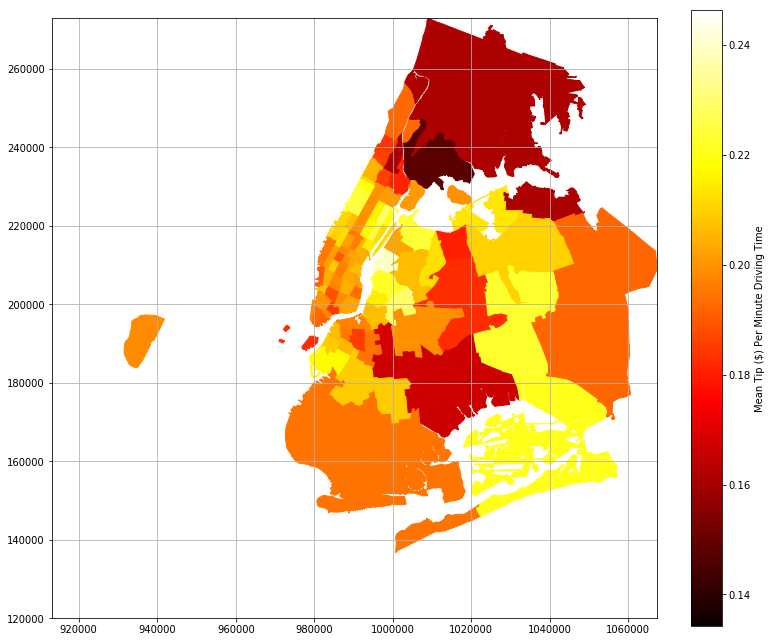

In [11]:
norm = mpl.colors.Normalize(
    vmin=samples['normalized_tip_time']['mean'].min()/1.1, 
    vmax=samples['normalized_tip_time']['mean'].max())
cmap = mpl.cm.hot
m = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)


for rec, zone in zip(sf.records(), sf.shapes()):
    if rec[-1] == 'Staten Island': continue

    locID = rec[-2]
    if locID in eff_ids.LocationID.unique():
        effLocID = eff_ids[eff_ids.LocationID == locID].EffectiveLocationID.values[0]

    try:
        tips = samples.loc[effLocID]['normalized_tip_time']['mean']
    except KeyError:
        tips = 0
    
    x = [z[0] for z in zone.points]
    y = [z[1] for z in zone.points]
    cb = plt.fill(x, y, c= m.to_rgba(tips))

m.set_array(cb)
cb = plt.colorbar(m, fraction=0.046, label='Mean Tip (\$) Per Minute Driving Time')
plt.gca().set_aspect(1)
plt.gca().grid()
plt.xlim([xmin, xmax])
plt.ylim([ymin, ymax])
plt.savefig('tip_by_region.pdf')

# Evaluate Significance

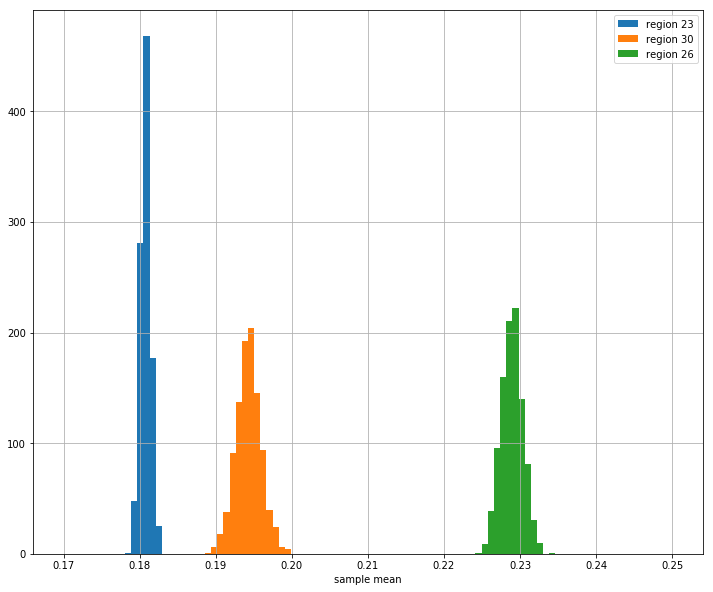

In [13]:
#
#  With such high standard deviations, it's not immediately obvious that our
#  results are significant. On the other hand, since we know that our data do
#  not follow a Gaussian distribution (see Mixture Models notebook), the
#  standard deviation is not a rigorous metric to evaluate significance. Here
#  I compute the variance in the sample mean for two regions via bootstrapping
#  to understand the significance of our resullts.
#

#  Since my implementation is slow, I just choose three regions. The goal is to provide
#  _evidence_ for significance, but I do not try to systematically establish this fact.
low_region = 23 
mid_region = 30 # also relatively low statistics, so likely high sample mean variance
high_region = 26

low = yellow[yellow.EffectiveLocationID == low_region]
mid = yellow[yellow.EffectiveLocationID == mid_region]
high = yellow[yellow.EffectiveLocationID == high_region]

low_means = [low.sample(frac=0.5)['normalized_tip_time'].mean() for _ in range(1000)]
mid_means = [mid.sample(frac=0.5)['normalized_tip_time'].mean() for _ in range(1000)]
high_means = [high.sample(frac=0.5)['normalized_tip_time'].mean() for _ in range(1000)]

mpl.rcParams['figure.figsize'] = (12, 10)
plt.hist(low_means, bins=np.linspace(0.17, 0.25, 100), label='region ' + str(low_region))
plt.hist(mid_means, bins=np.linspace(0.17, 0.25, 100), label='region ' + str(mid_region))
plt.hist(high_means, bins=np.linspace(0.17, 0.25, 100), label='region ' + str(high_region))
plt.grid()
plt.legend(loc='upper right')
plt.xlabel('sample mean')
plt.savefig('significance.pdf')

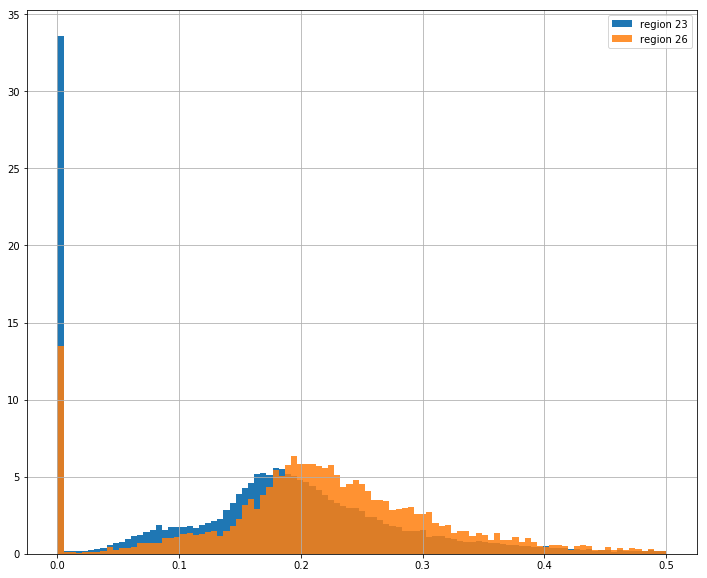

In [47]:
#
# visualize raw distributions
#
plt.hist(
    yellow[yellow.EffectiveLocationID == low_region]['normalized_tip_time'], 
    bins=np.linspace(0, 0.5, 100), label='region ' + str(low_region),
    normed=True)

plt.hist(
    yellow[yellow.EffectiveLocationID == high_region]['normalized_tip_time'],
    bins=np.linspace(0, 0.5, 100), 
    normed=True, label='region ' + str(high_region),
    alpha=0.85)

plt.grid()
plt.legend()

In [48]:
# ask KS what he thinks
stats.ks_2samp(
    yellow[(yellow.EffectiveLocationID == low_region) & (yellow.normalized_tip_time > 0)]['normalized_tip_time'],
    yellow[(yellow.EffectiveLocationID == high_region) & (yellow.normalized_tip_time > 0)]['normalized_tip_time']
)

Ks_2sampResult(statistic=0.1805643739297319, pvalue=7.619819599417523e-194)